## LIBRARY

In [1]:
import pandas as pd
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import scipy.io
import os
from tqdm import tqdm
import json
from scipy.stats import skew
from scipy.stats import kurtosis
import copy
import warnings
import math
from scipy.linalg import svd
from sklearn.decomposition import PCA
#import antropy as antt
from scipy.stats import entropy
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# from math import sqr

## Data Processing

In [3]:
dpath = "./data/"
mpath = "./output_transformer/"

files = os.listdir(dpath)
files.sort()

files = files[:10]
print(files)

['ADANIPORTS.csv', 'ASIANPAINT.csv', 'AXISBANK.csv', 'BAJAJ-AUTO.csv', 'BAJAJFINSV.csv', 'BAJFINANCE.csv', 'BHARTIARTL.csv', 'BPCL.csv', 'BRITANNIA.csv', 'CIPLA.csv']


In [4]:
def sample_creation(data_):
    input_size = 30
    output_size = 7
    
    # Calculate the total number of windows
    total_windows = data_.shape[0] - input_size - output_size + 1
    
    # Initialize lists to store input and output sets
    input_sets = []
    output_sets = []
    
    # Generate input and output sets using sliding window
    for i in range(total_windows):
        input_set = data_[i:i + input_size]
        output_set = data_[i + input_size:i + input_size + output_size]
        input_sets.append(input_set)
        output_sets.append(output_set)
    
    # Convert lists to numpy arrays
    input_sets = np.array(input_sets)
    output_sets = np.array(output_sets)    

    return input_sets, output_sets


def fetch_data(file, scaler):
    
    df=pd.read_csv(dpath + file).set_index('Date')
    df = df[["Close"]]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

    data = df.values
    
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    train_data = data[:train_set_size]
    test_data = data[-test_set_size:]
    
    #test data it is working fine or not
    x_train, y_train = sample_creation(train_data)
    x_test, y_test = sample_creation(test_data)

    return x_train , y_train , x_test , y_test , scaler


## MODEL

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, Input
from tensorflow.keras.models import Model
import numpy as np

class FourierTransformLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(FourierTransformLayer, self).__init__(**kwargs)
        self.axis = axis
    
    def call(self, x):
        # Perform the DFT and keep the real part
        x_ft = tf.signal.fft(tf.cast(x, tf.complex64))
        x_real = tf.math.real(x_ft)
        return x_real
    
    def get_config(self):
        config = super(FourierTransformLayer, self).get_config()
        config.update({"axis": self.axis})
        return config

class EncoderLayer(Layer):
    def __init__(self, d_model, dff, rate=0.1, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.ffn = PointWiseFeedForwardNetwork(d_model, dff)
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, x, training):
        # Apply DFT along the sequence dimension
        dft_seq = FourierTransformLayer(axis=1)(x)
        
        # Apply DFT along the hidden dimension
        dft_hidden = FourierTransformLayer(axis=2)(dft_seq)
        
        out1 = self.layernorm1(x + dft_hidden)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super(EncoderLayer, self).get_config()
        config.update({
            "d_model": self.ffn.dense2.units,
            "dff": self.ffn.dense1.units,
            "rate": self.dropout1.rate,
        })
        return config

class PointWiseFeedForwardNetwork(Layer):
    def __init__(self, d_model, dff, **kwargs):
        super(PointWiseFeedForwardNetwork, self).__init__(**kwargs)
        self.dense1 = Dense(dff, activation='relu')
        self.dense2 = Dense(d_model)
    
    def call(self, x):
        x = self.dense1(x)
        return self.dense2(x)
    
    def get_config(self):
        config = super(PointWiseFeedForwardNetwork, self).get_config()
        config.update({
            "d_model": self.dense2.units,
            "dff": self.dense1.units,
        })
        return config

class Encoder(Layer):
    def __init__(self, num_layers, d_model, dff, input_dim, maximum_position_encoding, rate=0.1, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = Dense(d_model)
        self.pos_encoding = self.positional_encoding(maximum_position_encoding, d_model)
        
        self.enc_layers = [EncoderLayer(d_model, dff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        sines = np.sin(angle_rads[:, 0::2])
        cosines = np.cos(angle_rads[:, 1::2])
        pos_encoding = np.concatenate([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates
    
    def call(self, x, training):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training)
        
        return x
    
    def get_config(self):
        config = super(Encoder, self).get_config()
        config.update({
            "num_layers": self.num_layers,
            "d_model": self.d_model,
            "dff": self.enc_layers[0].ffn.dense1.units,
            "input_dim": self.embedding.units,
            "maximum_position_encoding": self.pos_encoding.shape[1],
            "rate": self.dropout.rate,
        })
        return config

def build_transformer_model(input_shape, num_layers, d_model, dff, maximum_position_encoding, output_shape, rate=0.1):
    inputs = Input(shape=input_shape)
    encoder1 = Encoder(num_layers, d_model, dff, input_shape[-1], maximum_position_encoding, rate)
    enc_output1 = encoder1(inputs, training=True)

    outputs = Dense(output_shape[-1])(enc_output1[:,-7:,:])
    
    return Model(inputs=inputs, outputs=outputs)

input_shape = (30, 1)  # 96 time steps, 7 features
num_layers = 2
d_model = 512
dff = 2048
maximum_position_encoding = 10000
output_shape = (7, 1)  # 96 time steps, 7 features

transformer_model = build_transformer_model(input_shape, num_layers, d_model, dff, maximum_position_encoding, output_shape)
transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

transformer_model.summary()


2024-10-28 11:50:40.604742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-28 11:50:40.604781: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-28 11:50:45.632781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-28 11:50:45.632983: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-10-28 11:50:45.633108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: lib

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 encoder (Encoder)           (None, 30, 512)           4204544   
                                                                 
 tf.__operators__.getitem (S  (None, 7, 512)           0         
 licingOpLambda)                                                 
                                                                 
 dense_5 (Dense)             (None, 7, 1)              513       
                                                                 
Total params: 4,205,057
Trainable params: 4,205,057
Non-trainable params: 0
_________________________________________________________________


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

## TRAINING

In [7]:
def root_mean_square_error(array1, array2):
    # Ensure the two arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("The shapes of the input arrays must be the same.")
    
    # Compute the element-wise differences
    difference = array1 - array2
    
    # Square the differences
    squared_difference = np.square(difference)
    
    # Compute the mean of the squared differences
    mse = np.mean(squared_difference)

    error = mse ** 0.5
    
    return error

In [8]:
def mean_absolute_error(array1, array2):
    # Ensure the two arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("The shapes of the input arrays must be the same.")
    
    # Compute the element-wise differences
    difference = array1 - array2
    
    # Take the absolute value of the differences
    absolute_difference = np.abs(difference)
    
    # Compute the mean of the absolute differences
    error = np.mean(absolute_difference)
    
    return error

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 1/100
82/82 [==============================] - ETA: 0s - loss: 8.3266 - mae: 0.9695
Epoch 1: val_loss improved from inf to 0.14035, saving model to ./weights_transformer/ADANIPORTS.csv.h5
82/82 [==============================] - 54s 629ms/step - loss: 8.3266 - mae: 0.9695 - val_loss: 0.1403 - val_mae: 0.2730
Epoch 2/100
82/82 [==============================] - ETA: 0s - loss: 0.0593 - mae: 0.1938
Epoch 2: val_loss did not improve from 0.14035
82/82 [==============================] - 50s 606ms/step - loss: 0.0593 - mae: 0.1938 - val_loss: 0.1954 - val_mae: 0.2760
Epoch 3/100
82/82 [==============================] - ETA: 0s - loss: 0.0486 - mae: 0.1754
Epoch 3: val_loss did not improve from 0.14035
82/82 [==============================] - 49s 604ms/step - loss: 0.0486 - mae: 0.1754 - val_loss: 0.1625 - val_mae: 0.2465
Epoch 4/100
82/82 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.1327
Epoch 4: val_loss did not improve from 0.14035
82/82 [======================

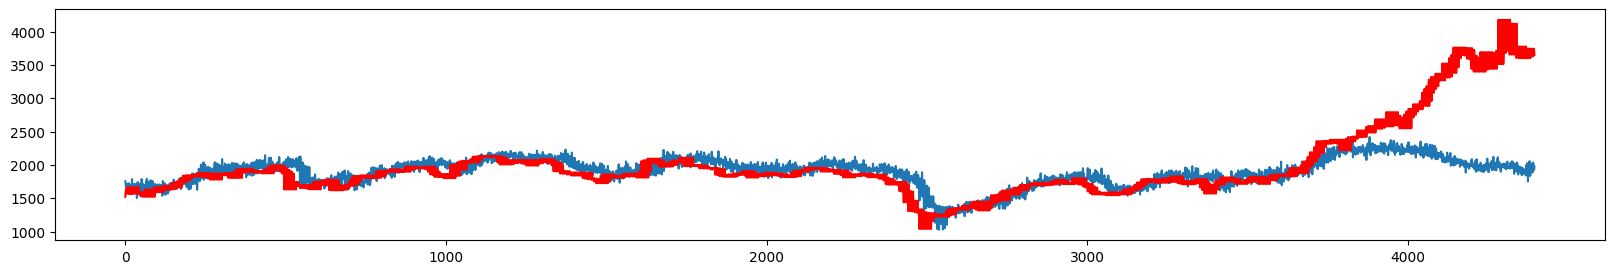

 10%|████████                                                                        | 1/10 [32:13<4:50:02, 1933.62s/it]

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0273
Epoch 1: val_loss improved from inf to 0.12527, saving model to ./weights_transformer/ASIANPAINT.csv.h5
132/132 [==============================] - 82s 618ms/step - loss: 0.0012 - mae: 0.0273 - val_loss: 0.1253 - val_mae: 0.2145
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 8.7825e-04 - mae: 0.0235
Epoch 2: val_loss did not improve from 0.12527
132/132 [==============================] - 81s 616ms/step - loss: 8.7825e-04 - mae: 0.0235 - val_loss: 0.1348 - val_mae: 0.2327
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 7.4568e-04 - mae: 0.0215
Epoch 3: val_loss did not improve from 0.12527
132/132 [==============================] - 81s 616ms/step - loss: 7.4568e-04 - mae: 0.0215 - val_loss: 0.1299 - val_mae: 0.2240
Epoch 4/100
132/132 [==============================] - ETA: 0s - loss: 7.0550e-04 - mae: 0.0208
Epoch 4: val_loss did not improve from 0.1

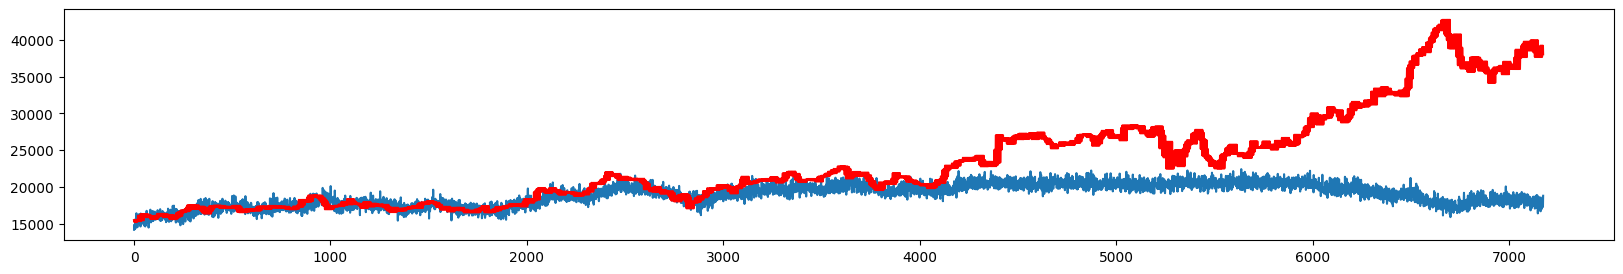

 20%|████████████████                                                                | 2/10 [40:29<2:25:03, 1088.00s/it]

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0411
Epoch 1: val_loss improved from inf to 0.04603, saving model to ./weights_transformer/AXISBANK.csv.h5
132/132 [==============================] - 81s 617ms/step - loss: 0.0031 - mae: 0.0411 - val_loss: 0.0460 - val_mae: 0.1641
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0363
Epoch 2: val_loss improved from 0.04603 to 0.04421, saving model to ./weights_transformer/AXISBANK.csv.h5
132/132 [==============================] - 81s 617ms/step - loss: 0.0023 - mae: 0.0363 - val_loss: 0.0442 - val_mae: 0.1598
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0361
Epoch 3: val_loss did not improve from 0.04421
132/132 [==============================] - 81s 616ms/step - loss: 0.0022 - mae: 0.0361 - val_loss: 0.0483 - val_mae: 0.1687
Epoch 4/100
132/132 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0344
Epoch

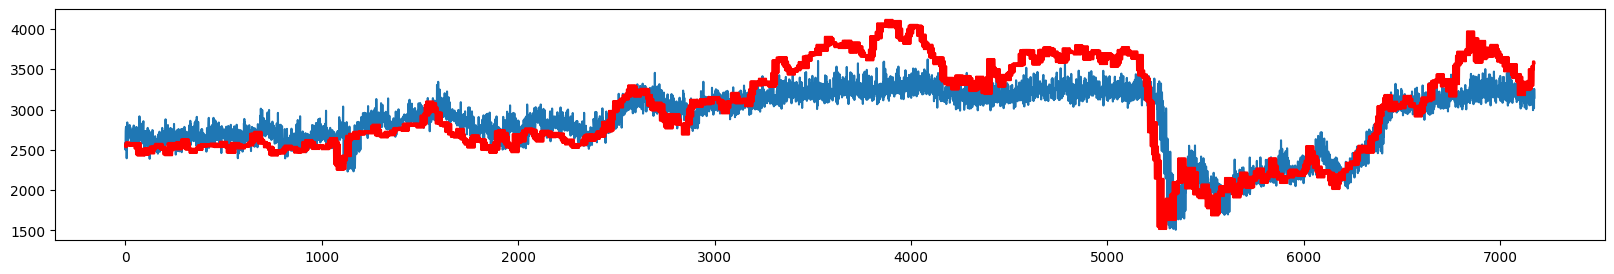

 30%|████████████████████████                                                        | 3/10 [55:33<1:57:08, 1004.03s/it]

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0443
Epoch 1: val_loss improved from inf to 0.01118, saving model to ./weights_transformer/BAJAJ-AUTO.csv.h5
79/79 [==============================] - 49s 618ms/step - loss: 0.0032 - mae: 0.0443 - val_loss: 0.0112 - val_mae: 0.0748
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0381
Epoch 2: val_loss improved from 0.01118 to 0.01058, saving model to ./weights_transformer/BAJAJ-AUTO.csv.h5
79/79 [==============================] - 49s 623ms/step - loss: 0.0024 - mae: 0.0381 - val_loss: 0.0106 - val_mae: 0.0743
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0391
Epoch 3: val_loss did not improve from 0.01058
79/79 [==============================] - 49s 624ms/step - loss: 0.0025 - mae: 0.0391 - val_loss: 0.0128 - val_mae: 0.0836
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0401
Epoch 4: val_lo

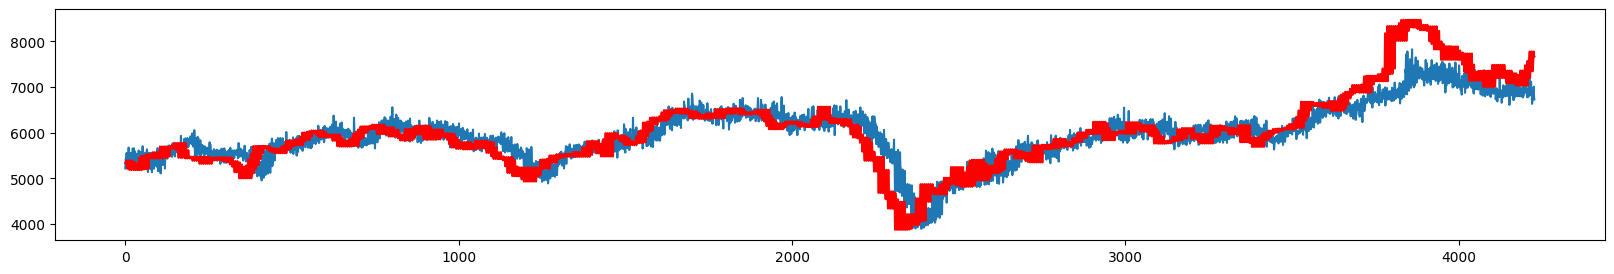

 40%|███████████████████████████████▌                                               | 4/10 [1:07:05<1:28:04, 880.69s/it]

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0362
Epoch 1: val_loss improved from inf to 0.01491, saving model to ./weights_transformer/BAJAJFINSV.csv.h5
79/79 [==============================] - 49s 619ms/step - loss: 0.0023 - mae: 0.0362 - val_loss: 0.0149 - val_mae: 0.0921
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0279
Epoch 2: val_loss improved from 0.01491 to 0.01239, saving model to ./weights_transformer/BAJAJFINSV.csv.h5
79/79 [==============================] - 49s 625ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 0.0124 - val_mae: 0.0807
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 9.6671e-04 - mae: 0.0233
Epoch 3: val_loss did not improve from 0.01239
79/79 [==============================] - 49s 619ms/step - loss: 9.6671e-04 - mae: 0.0233 - val_loss: 0.0149 - val_mae: 0.0916
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 9.6055e-04 - mae: 0.0235
Epo

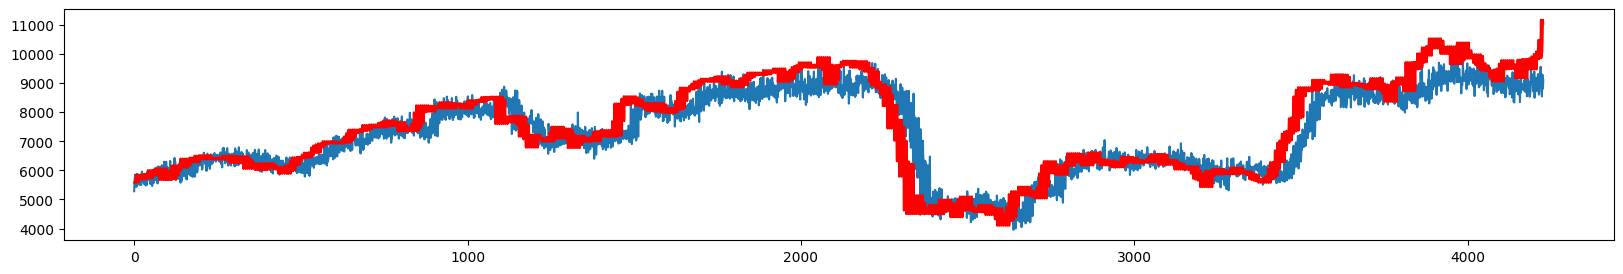

 50%|████████████████████████████████████████▌                                        | 5/10 [1:12:53<57:22, 688.60s/it]

Epoch 1/100
130/130 [==============================] - ETA: 0s - loss: 8.4151e-04 - mae: 0.0200
Epoch 1: val_loss improved from inf to 0.03236, saving model to ./weights_transformer/BAJFINANCE.csv.h5
130/130 [==============================] - 81s 623ms/step - loss: 8.4151e-04 - mae: 0.0200 - val_loss: 0.0324 - val_mae: 0.1328
Epoch 2/100
130/130 [==============================] - ETA: 0s - loss: 8.2401e-04 - mae: 0.0202
Epoch 2: val_loss did not improve from 0.03236
130/130 [==============================] - 81s 622ms/step - loss: 8.2401e-04 - mae: 0.0202 - val_loss: 0.0500 - val_mae: 0.1679
Epoch 3/100
130/130 [==============================] - ETA: 0s - loss: 7.2060e-04 - mae: 0.0182
Epoch 3: val_loss did not improve from 0.03236
130/130 [==============================] - 80s 618ms/step - loss: 7.2060e-04 - mae: 0.0182 - val_loss: 0.0670 - val_mae: 0.2004
Epoch 4/100
130/130 [==============================] - ETA: 0s - loss: 7.7346e-04 - mae: 0.0197
Epoch 4: val_loss did not improve 

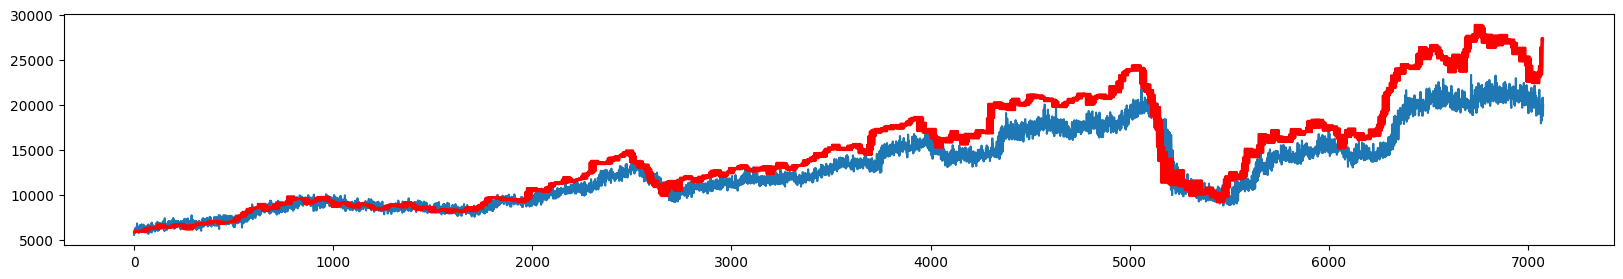

 60%|████████████████████████████████████████████████▌                                | 6/10 [1:21:04<41:25, 621.47s/it]

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0568
Epoch 1: val_loss improved from inf to 0.01361, saving model to ./weights_transformer/BHARTIARTL.csv.h5
119/119 [==============================] - 74s 622ms/step - loss: 0.0058 - mae: 0.0568 - val_loss: 0.0136 - val_mae: 0.0899
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0553
Epoch 2: val_loss did not improve from 0.01361
119/119 [==============================] - 73s 617ms/step - loss: 0.0051 - mae: 0.0553 - val_loss: 0.0187 - val_mae: 0.1058
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0509
Epoch 3: val_loss did not improve from 0.01361
119/119 [==============================] - 73s 617ms/step - loss: 0.0044 - mae: 0.0509 - val_loss: 0.0208 - val_mae: 0.1072
Epoch 4/100
119/119 [==============================] - ETA: 0s - loss: 0.0043 - mae: 0.0496
Epoch 4: val_loss did not improve from 0.01361
119/119 [======

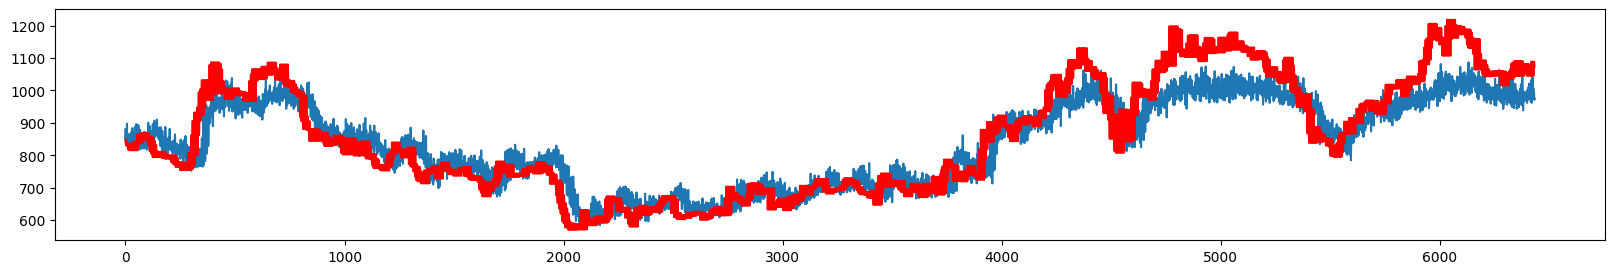

 70%|████████████████████████████████████████████████████████▋                        | 7/10 [1:28:34<28:15, 565.30s/it]

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0321
Epoch 1: val_loss improved from inf to 0.01813, saving model to ./weights_transformer/BPCL.csv.h5
132/132 [==============================] - 82s 622ms/step - loss: 0.0017 - mae: 0.0321 - val_loss: 0.0181 - val_mae: 0.1063
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0283
Epoch 2: val_loss did not improve from 0.01813
132/132 [==============================] - 82s 619ms/step - loss: 0.0014 - mae: 0.0283 - val_loss: 0.0191 - val_mae: 0.1074
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0274
Epoch 3: val_loss did not improve from 0.01813
132/132 [==============================] - 81s 617ms/step - loss: 0.0013 - mae: 0.0274 - val_loss: 0.0196 - val_mae: 0.1089
Epoch 4/100
132/132 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0266
Epoch 4: val_loss did not improve from 0.01813
132/132 [============

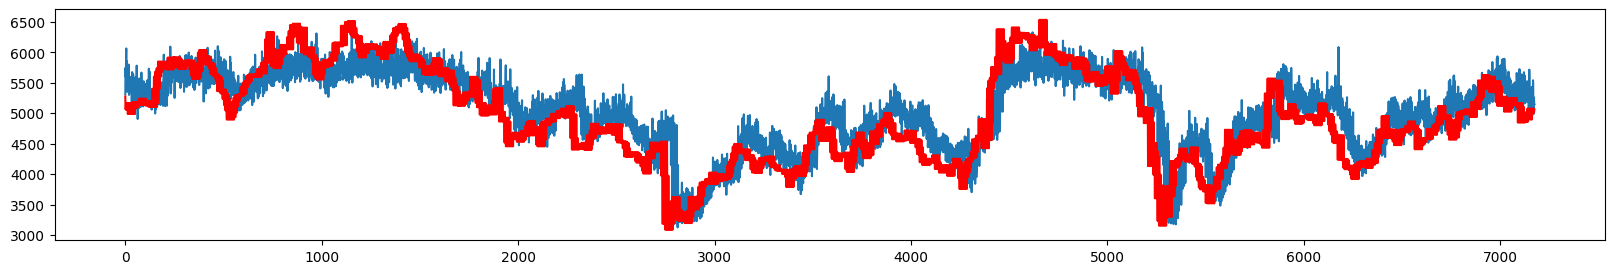

 80%|████████████████████████████████████████████████████████████████▊                | 8/10 [1:42:19<21:36, 648.05s/it]

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 6.6667e-04 - mae: 0.0195
Epoch 1: val_loss improved from inf to 0.05116, saving model to ./weights_transformer/BRITANNIA.csv.h5
132/132 [==============================] - 82s 619ms/step - loss: 6.6667e-04 - mae: 0.0195 - val_loss: 0.0512 - val_mae: 0.1904
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 5.4648e-04 - mae: 0.0176
Epoch 2: val_loss did not improve from 0.05116
132/132 [==============================] - 81s 617ms/step - loss: 5.4648e-04 - mae: 0.0176 - val_loss: 0.0549 - val_mae: 0.1955
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 6.1636e-04 - mae: 0.0191
Epoch 3: val_loss did not improve from 0.05116
132/132 [==============================] - 81s 617ms/step - loss: 6.1636e-04 - mae: 0.0191 - val_loss: 0.0717 - val_mae: 0.2292
Epoch 4/100
132/132 [==============================] - ETA: 0s - loss: 6.1763e-04 - mae: 0.0188
Epoch 4: val_loss did not improve f

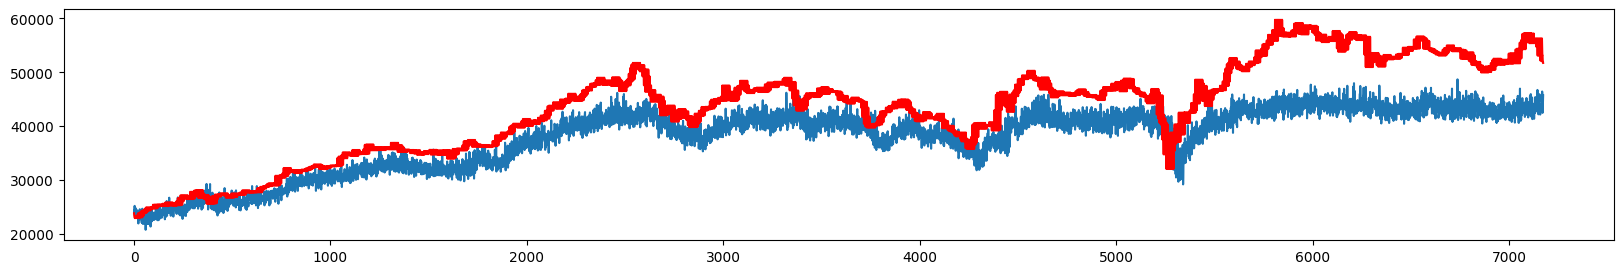

 90%|████████████████████████████████████████████████████████████████████████▉        | 9/10 [1:50:49<10:04, 604.96s/it]

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.0455
Epoch 1: val_loss improved from inf to 0.01167, saving model to ./weights_transformer/CIPLA.csv.h5
132/132 [==============================] - 80s 603ms/step - loss: 0.0037 - mae: 0.0455 - val_loss: 0.0117 - val_mae: 0.0740
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0344
Epoch 2: val_loss did not improve from 0.01167
132/132 [==============================] - 79s 600ms/step - loss: 0.0024 - mae: 0.0344 - val_loss: 0.0143 - val_mae: 0.0782
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0349
Epoch 3: val_loss did not improve from 0.01167
132/132 [==============================] - 79s 600ms/step - loss: 0.0024 - mae: 0.0349 - val_loss: 0.0118 - val_mae: 0.0714
Epoch 4/100
132/132 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0360
Epoch 4: val_loss improved from 0.01167 to 0.01108, saving model to

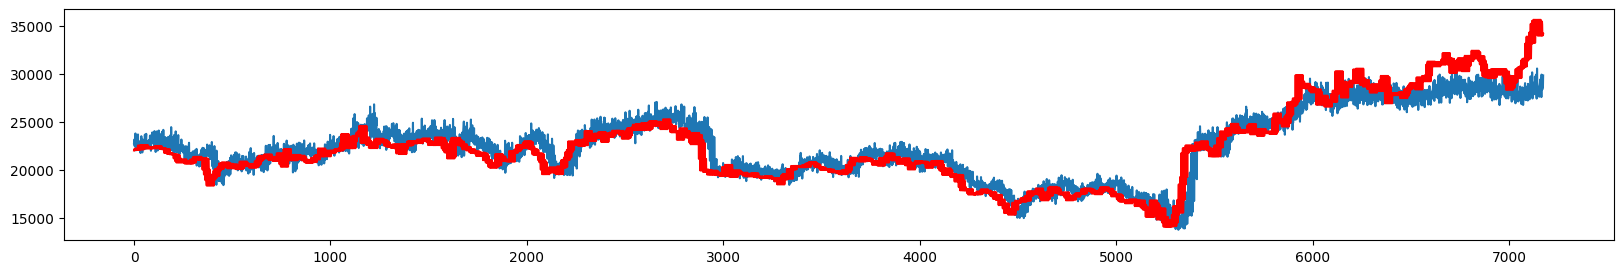

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [2:13:29<00:00, 801.00s/it]


In [9]:
i = -1
rmse = []
maes = []
for file in tqdm(files):
    i += 1
    # scaler = scalers[i]
    x_train , y_train , x_test , y_test, scaler = fetch_data(file, scaler)

    weights_dir = './weights_transformer/'


    os.makedirs(weights_dir, exist_ok=True)
    file_name = file + '.h5'
    file_path = os.path.join(weights_dir, file_name)

    # ModelCheckpoint to save the best model weights
    mc1 = ModelCheckpoint(file_path,  # Path to save weights
                         monitor='val_loss',  # Monitor validation loss
                         mode='min',  # We want to minimize the loss
                         save_best_only=True,  # Save only the best weights
                         verbose=1)  # Display when saving occurs

    es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    x_train=np.asarray(x_train).astype(np.float32)
    #x_val=np.asarray(x_val).astype(np.float32)
    x_test=np.asarray(x_test).astype(np.float32)

    y_train=np.asarray(y_train).astype(np.float32)
    #y_val=np.asarray(y_val).astype(np.float32)
    y_test=np.asarray(y_test).astype(np.float32)

    hist1=transformer_model.fit(x_train,y_train,batch_size=32,epochs=100, verbose = 1,callbacks=[es1,mc1],
                   validation_data=(x_test,y_test))

    transformer_model.load_weights(file_path)

    
    # x_test = scaler.transform(x_test)
    pred = transformer_model.predict(x_test)

    if pred.ndim == 3:
    # Flatten 3D array (samples, timesteps, features) to 2D
        pred_shape = pred.shape
        pred = pred.reshape(pred_shape[0] * pred_shape[1], pred_shape[2])

    # Apply inverse transform
    pred_unscaled = scaler.inverse_transform(pred)

    # Same for y_test if it's 3D
    if y_test.ndim == 3:
        y_test_shape = y_test.shape
        y_test = y_test.reshape(y_test_shape[0] * y_test_shape[1], y_test_shape[2])

    y_test_unscaled = scaler.inverse_transform(y_test)

    plt.figure(figsize=(20,3))
    plt.plot(pred_unscaled.flatten())
    plt.plot(y_test_unscaled.flatten(),color='red')
    plt.show()
    # print(mean_square_error(y_test, pred))
    rmse.append(root_mean_square_error(y_test_unscaled, pred_unscaled))
    maes.append(mean_absolute_error(y_test_unscaled, pred_unscaled))

In [10]:
print(rmse)
print(maes)

[468.8967770202734, 7523.525503379383, 312.82115997003785, 364.8943554304451, 619.0314763806441, 2577.201486108527, 70.02527445501374, 408.6839587321724, 6639.679209118464, 1521.1482505002593]
[228.01007, 4556.3, 240.07048, 260.90033, 450.0497, 1907.8859, 54.188828, 320.68378, 5567.824, 1100.9188]
